In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

np.random.seed(42)

In [2]:
def fetch_image(response):
    res = cv2.imdecode(np.asarray(bytearray(response.content)), cv2.IMREAD_COLOR)
    assert type(res) != None, f"Failed downloading from {response.url}"
    return res


def fetch_images(urls):
    return [fetch_image(requests.get(url)) for url in urls]


IMAGES_HIGH_RES = fetch_images(
    [
        "https://ithemes.com/wp-content/uploads/2016/10/Free-High-Quality-Images-Gratisography.jpg",
        "https://ithemes.com/wp-content/uploads/2016/10/Free-High-Quality-Images-Unsplash.jpeg",
        "https://ithemes.com/wp-content/uploads/2016/10/Pixabay.jpg",
        "https://ithemes.com/wp-content/uploads/2016/10/Free-High-Quality-Images-Lock-and-Stock-Photos.jpg",
        "https://ithemes.com/wp-content/uploads/2016/10/Free-High-Quality-Images-Picography-e1477688691166.jpg",
        "https://iso.500px.com/wp-content/uploads/2014/06/W4A2827-1-3000x2000.jpg",
    ]
)

In [3]:
def apply_transformation(transformation, imgs=IMAGES_HIGH_RES, fig_size=8, **kwargs):
    assert 2 <= len(imgs), "Provide at leat 2 images"

    fig, axs = plt.subplots(len(imgs), 2, figsize=(fig_size, fig_size))
    i = 0
    for img in imgs:
        transformed_img = transformation(img, **kwargs)
        axs[i, 0].imshow(img)
        axs[i, 0].axis("off")
        axs[i, 1].imshow(transformed_img)
        axs[i, 1].axis("off")
        i += 1
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()


def apply_transformation_on_random(
    transformation, imgs=IMAGES_HIGH_RES, imgs_num=2, **kwargs
):
    assert (
        2 <= imgs_num <= len(imgs)
    ), "Images num must be between 2 and number of provided images"
    idxs = np.random.choice(np.arange(len(imgs)), imgs_num, replace=False)
    choosen_imgs = [imgs[i] for i in idxs]
    return apply_transformation(transformation, choosen_imgs, **kwargs)

# Filtracja obrazów

### Filtracja dolnoprzepustowa

Redukuje wysokie częstotliwości, wygładając obraz i redukując szumy

In [4]:
def filtr_dolnoprzepustowy_srednia(img, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (
        kernel_size * kernel_size
    )
    return cv2.filter2D(img, -1, kernel)


def filtr_dolnoprzepustowy_gauss(img, kernel_size=5, sigma=0):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)


noisy_images = fetch_images(
    [
        "https://media.cheggcdn.com/media/8c7/8c7f3063-bccd-49ef-a483-c160557d6ef4/phpAtYk4M.png",
        "https://people.math.sc.edu/Burkardt/c_src/image_denoise/balloons_noisy.png",
    ]
)

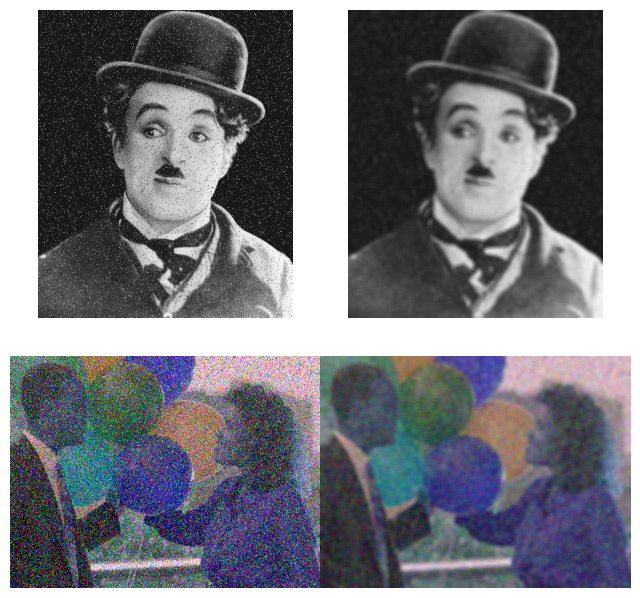

In [5]:
# uzywając sredniej wartosci pikseli
apply_transformation(filtr_dolnoprzepustowy_srednia, imgs=noisy_images, kernel_size=10)

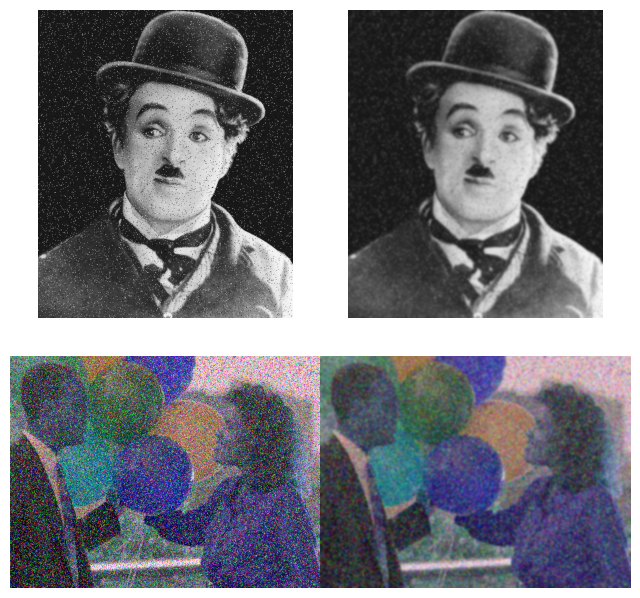

In [6]:
# uzywając gaussian filter
apply_transformation(filtr_dolnoprzepustowy_gauss, imgs=noisy_images, kernel_size=11)

### Filtracja górnoprzepustowa

Redukuje niskie częstotliwości, wydobywając krawędzie i detale obrazu.

In [7]:
def high_pass_filter_laplacian(img, kernel_size):
    filtered_image = cv2.Laplacian(img, cv2.CV_64F, ksize=kernel_size)
    return cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)


blured_images = fetch_images(
    [
        "https://images.ctfassets.net/u4vv676b8z52/aLsx9SoEj0jI9nkHuEiB6/b128cc239af84fd9b969fc037693df7b/jack-russell-blurred-1200x630.jpg_h_250?fm=jpg&q=80",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTSjNhOl7lhalkb9B1VXL1kfPDKRK5p7Vh6iMTao_wjTHPuSl-mvuqe3AFxLqcinSMkRE4&usqp=CAU",
    ]
)

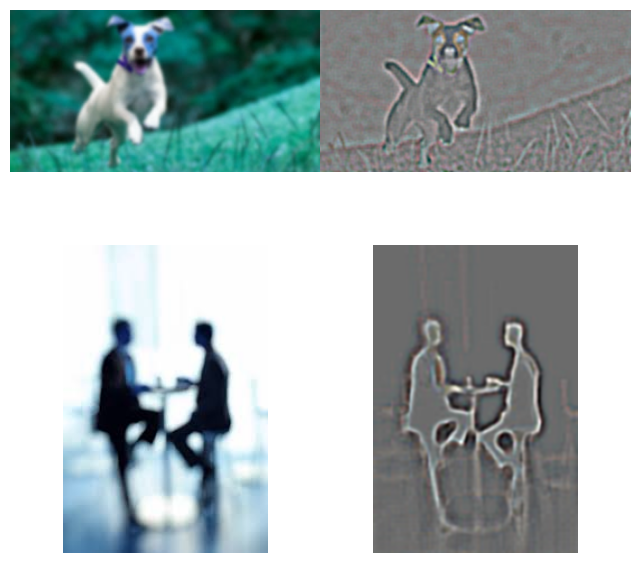

In [8]:
# Laplacian filter
apply_transformation(high_pass_filter_laplacian, imgs=blured_images, kernel_size=11)

### Filtracja medianowa

 Redukuje szumy impulsowe, zastępując wartość piksela medianą w jego otoczeniu.

### Filtracja adaptacyjna

Dostosowuje parametry filtra do lokalnych cech obrazu, poprawiając jakość w obszarach o zróżnicowanej jasności lub kontraście.

### Filtracja bilateralna

Wygładza obraz, zachowując jednocześnie krawędzie i szczegóły poprzez uwzględnienie informacji o intensywności piksela i jego otoczeniu.

### Filtracja krawędziowa

Wyodrębnia krawędzie i detale obrazu poprzez podkreślenie zmian intensywności pikseli wzdłuż krawędzi. Przykłady to operator Sobela i operator Laplace'a.

### Filtracja adaptacyjna lokalna

Dostosowuje parametry filtra do lokalnych cech obrazu, co pozwala na bardziej precyzyjne filtrowanie w obszarach o zróżnicowanej jasności lub kontraście. Jest skuteczna w redukcji szumów i poprawie jakości obrazu.

### Filtracja tekstur

 Wzmocnienie lub redukcja tekstur w obrazie dla podkreślenia lub wygładzenia cech teksturalnych.

### Filtracja anizotropowa

Wygładza obraz, uwzględniając kierunkowość struktur.

### Filtracja kolorowa

Uwzględnia składniki kolorowe obrazu podczas filtracji, wpływając na wygląd kolorów.

# Przekształcenia geometryczne obrazów

### Skalowanie

 Zmienia rozmiar obrazu, przy czym metoda interpolacji może wpływać na jakość i dokładność transformacji.

### Obrót

Zmienia orientację obrazu, a odpowiednia metoda interpolacji może wpływać na zachowanie szczegółów i jakość obrazu.

### Przesunięcie

Przesuwa obraz względem osi, a interpolacja może wpływać na jakość przesunięcia.

### Perspektywa

Zmienia perspektywę obrazu, przy czym efekty mogą obejmować korekcję perspektywy i tworzenie efektów trójwymiarowych.

### Transformacje morfologiczne

Operacje, takie jak dylatacja i erozja, mogą służyć do zmiany kształtów i struktur obrazu.

### Rejestracja obrazów

Dopasowanie wielu obrazów w celu stworzenia spójnego obrazu, przydatne w tworzeniu panoram lub analizie

### Transformacje falkowe

Wykorzystuje transformacje falkowe, takie jak transformata Fouriera czy transformata falkowa, do analizy częstotliwościowej obrazu i wyodrębniania szczegółów.

### Korekcja chromatyczna

Poprawia balans kolorów w obrazach, eliminując niepożądane odcienie i dostosowując reprodukcję kolorów.

### Odwracanie obrazu

Zmienia wartości pikseli na przeciwną, co może tworzyć efekty lustrzane lub artystyczne.

### Zwiększanie rozdzielczości obrazu

Wykorzystuje informacje z wielu obrazów do zwiększenia rozdzielczości i uzyskania bardziej szczegółowego obrazu.

In [9]:
low_res_imgs = fetch_images(
    [
        "https://i.pinimg.com/736x/60/b0/95/60b095f51b0b5e689ec0b503fcb1c37b.jpg",
        "https://i1.sndcdn.com/artworks-000486312813-afsh6w-t500x500.jpg",
        "https://64.media.tumblr.com/93a9f8679b5f8639b973a1c1a04a02ab/tumblr_oqllx2Bk1H1v9ks36o1_1280.jpg",
    ]
)